# Visualizing the distribution of totals
This script uses data from the OpenPowerlifting project (https://www.openpowerlifting.org). <br>
You may download a copy of the data at https://gitlab.com/openpowerlifting/opl-data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import bisect
from scipy import stats

%matplotlib inline

In [2]:
data_types = {
              'Name': str,
              'Sex': str,
              'Event': str,
              'Equipment': str,
              'WeightClassKg': str,
              'TotalKg': float
             }

opl = pd.read_csv('openpowerlifting.csv', dtype=data_types, usecols=list(data_types))

In [3]:
opl.rename(columns={'TotalKg':'Total'}, inplace=True)

#### Parameters

In [4]:
weight_class = ['82.5']
sex = 'M'
equipment = ['Raw']

my_name = 'Julien Comte'

In [5]:
parameter_mask = ((opl.WeightClassKg.isin(weight_class))
                  & (opl.Sex == sex)
                  & (opl.Equipment.isin(equipment))
                  & (opl.Event == 'SBD')
                  & (opl.Total.notna()))

opl_filtered = opl[parameter_mask]

In [6]:
best_totals = opl_filtered.groupby('Name')['Total'].max()

In [7]:
my_best_total = opl_filtered.loc[opl_filtered['Name'] == my_name]['Total'].max()

#### Histogram

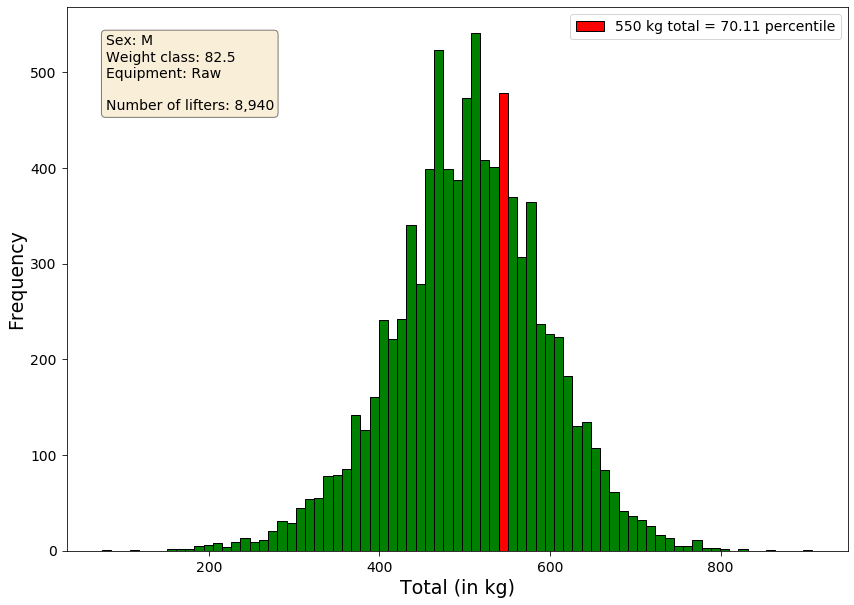

In [8]:
fig = plt.figure(figsize=(14, 10))

ax = fig.add_subplot()

n, bins, patches = ax.hist(best_totals, bins='auto', color='green', edgecolor='black')

# chart formatting
ax.set_xlabel('Total (in kg)', size=19)
ax.set_ylabel('Frequency', size=19)
plt.yticks(size=14)
plt.xticks(size=14)
ax.tick_params(axis='both', which='major', pad=5, length=5)

# my bin (rightmost value less than or equal to my_total)
bisect_index = bisect.bisect_right(bins, my_best_total)

if bisect_index == len(bins):
    index_to_highlight = -1
else:
    index_to_highlight = bisect_index - 1
    
patches[index_to_highlight].set_facecolor('red')

# my percentile
percentile = stats.percentileofscore(best_totals, my_best_total, kind='mean')
ax.legend([patches[index_to_highlight]], [f'{my_best_total:g} kg total = {percentile:.2f} percentile'], prop={"size":14})

# textbox with parameters
parameters = '\n'.join((
   f'Sex: {sex}',
   f'Weight class: {", ".join(str(x) for x in weight_class)}',
   f'Equipment: {", ".join(str(x) for x in equipment)}',
   '\n'
   f'Number of lifters: {best_totals.count():,}'))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, parameters, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.show()

In [9]:
pd.set_option('precision', 1)

# descriptive statistics
best_totals.describe(percentiles=[.25, .50, .75, .99]).to_frame()

,Total
count,8940.0
mean,504.8
std,89.2
min,75.0
25%,450.0
50%,505.8
75%,562.5
99%,712.5
max,907.5
